In [2]:
import random
import numpy as np
import scanpy as sc
import anndata as an
import scipy.stats as st
from scipy.spatial import KDTree
import math
from numba import njit
from numba import jit
from typing import *


import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["figure.facecolor"] = "white"

DEBUG = False

In [3]:
DATA_PTH = "/Users/juliafoyer/Documents/Skolarbete/Masters_thesis/human_breast_cancer_ST_data"

In [6]:
def prepare_data(adata : an.AnnData, select_hvg : bool = True)-> an.AnnData:
    adata.var_names_make_unique()
    X = np.array(adata.X.todense())
    adata.X = X
    if select_hvg:
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, n_top_genes = 1000)
        adata = adata[:,adata.var.highly_variable.values]
        adata.X = (np.exp(adata.X) -1).round(0)
    return adata

In [7]:
def gibbsSampling():
    for d, doc in enumerate(ids):
        for index, w in enumerate(doc):
            z = umi_factors[d][index]
            dt[d, z] -= 1
            wt[z, w] -= 1
            nz[z] -= 1
            pz = np.divide(np.multiply(dt[d, :], wt[:, w]), nz)
            z = np.random.multinomial(1, (pz / pz.sum())).argmax()
            umi_factors[d][index] = z 
            dt[d, z] += 1
            wt[z, w] += 1
            nz[z] += 1

In [8]:
adata = sc.read_visium(DATA_PTH)
adata = prepare_data(adata,select_hvg=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
def subsample(adata):
    n_spots, n_genes = adata.X.shape
    N_s = adata.X.sum(axis=1).astype(np.float64)
    for spot in range(n_spots):
        p_s = adata.X[spot,:].astype(np.float64) / N_s[spot] # one per gene, i.e, 1000
        p_s = p_s.astype(np.float64)
        n = int(np.ceil(0.1*N_s[spot]))
        new_x_s = np.random.multinomial(n,p_s)
        adata.X[spot,:] = new_x_s
    return adata  

In [11]:
adata = subsample(adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
def plot_theta2(adata, dt,s=5):
    theta = get_theta(dt)
    crd = adata.obsm["spatial"]
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.scatter(crd[:,1],crd[:,0],c = theta,s=s,edgecolor = "none")
    ax.set_aspect("equal")
    for sp in ax.spines.keys():
        ax.spines[sp].set_visible(False)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #plt.invert_yaxis()
    plt.show()

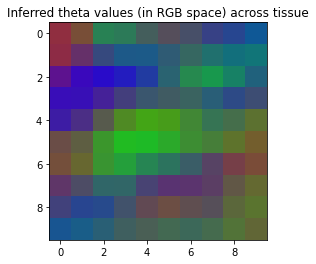

In [7]:
side_length = adata.uns["info"]["side_length"]
plt.imshow(adata.obsm["theta"].reshape(side_length,side_length,3))
plt.title("Inferred theta values (in RGB space) across tissue")
plt.show()

## Define LDAdataset

In [19]:
class LDAdataset:
    def __init__(self,
                 matrix: np.ndarray,
                 crd: np.ndarray,
                 n_topics: int = 3,
                 alpha: float = 0.1,
                 beta: float = 0.1,
                 nn: int = 6,
                ):
        
        self.X = matrix
        self.crd = crd
        
        self.alpha = alpha
        self.beta = beta
        self.l = 5
        
        self.Nd = self.X.sum(axis=1).astype(int)
        self.N = self.Nd.sum().astype(int)
        self.K = n_topics
        self.D = self.X.shape[0]
        self.W = self.X.shape[1]
        self.dt = np.zeros((self.D,self.K)) + self.alpha
        self.tw = np.zeros((self.K,self.W)) + self.beta
        self.nz = np.zeros(self.K)
        
        self.ztl = np.zeros(self.N,dtype=int)
        self.dtl = np.zeros(self.N,dtype=int)
        self.wtl = np.zeros(self.N,dtype=int)
        
        self.theta = np.zeros((self.N,self.K),dtype=np.float64)
        self.phi = np.zeros((self.K,self.W),dtype = np.float64)
        
        self.nn = nn
        self.nbrmat = np.zeros((self.N,self.nn),dtype = int)
        self.nbrmask = np.zeros((self.N,self.nn),dtype = int)
        self._build_nbrhd()
        
        self._initialize()
        
        
    def _build_nbrhd(self,):
        kd = KDTree(self.crd)
        dist,idx = kd.query(self.crd,k = self.nn)
        no_nbr = np.isinf(dist)
        dist[no_nbr] = 0
        dist[~no_nbr] = 1
        idx[no_nbr] = -1
        self.nbrmask = dist
        self.nbrmat = idx
        
    
    def distance_fun(self,p,q):
        #Bhattacharyya distance
        return - np.log(np.sqrt(p*q).sum())
        
    
    def log_potential(self,theta_a,theta_b):
        return -self.l * self.distance_fun(theta_a,theta_b)
    
    
    def _sample_theta(self,d,n_iter = 10):
        
        proposal_dist = st.dirichlet(self.dt[d,:])
        
        theta_mat = np.zeros((n_iter+1,self.K))
        
        theta_mat[0,:] = self.theta[d,:]
        old_log_proposal = proposal_dist.logpdf(theta_mat[0,:])
        old_log_target = self.log_potential(theta_mat[0,:],self.theta[self.nbrmat[d,:]])
        old_log_target *= self.nbrmask[d,:] # look up and compare to dist[spot,:]
        old_log_target = old_log_target.sum()

        for it in range(1,n_iter+1):
            new_theta = proposal_dist.rvs()[0]
            new_log_proposal = proposal_dist.logpdf(new_theta)
            new_log_target = self.log_potential(new_theta,self.theta[self.nbrmat[d,:]])
            new_log_target *= self.nbrmask[d,:]
            new_log_target = new_log_target.sum()
            
            
            log_u = new_log_target + old_log_proposal - old_log_target - new_log_proposal
            u = np.exp(log_u) 
            a = min(u,1)

            if np.random.random() < a:
                theta_mat[it,:] = new_theta
                old_log_target = new_log_target
                old_log_proposal = new_log_proposal
            else:
                theta_mat[it,:] = theta_mat[it-1,:]
                
        self.theta[d,:] = theta_mat.mean(axis=0)
        
        
    def _initialize(self,):
        
        w_tot = 0
        for d in range(self.D):
            for w in range(self.W):
                for ii in range(int(self.X[d,w])):
                    z = w_tot % self.K
                    self.dt[d,z] +=1
                    self.tw[z,w] +=1
                    self.nz[z] +=1
                    
                    self.ztl[w_tot] = z
                    self.wtl[w_tot] = w
                    self.dtl[w_tot] = d
                    w_tot += 1
                    
        self._update_theta()
        self._update_phi()
        
    def _update_theta(self,):
        self.theta = self.dt / self.dt.sum(axis=1, keepdims=True)
        
    def _update_phi(self,):
        self.phi = self.tw / self.tw.sum(axis=0,keepdims = True)
    
    def vanillaGibbsSampling(self,n_iter):
        for it in range(n_iter):
            print("\rIteration {}".format(it),end="")
            for ii in range(self.N):
                z = self.ztl[ii]
                d = self.dtl[ii]
                w = self.wtl[ii]

                self.dt[d, z] -= 1
                self.tw[z, w] -= 1
                self.nz[z] -= 1

                
                pz = np.divide(np.multiply(self.dt[d, :], self.tw[:, w]), self.nz)
                pz = pz / pz.sum()
                
                new_z = np.random.multinomial(1, pz).argmax()

                self.ztl[ii] = new_z
                self.dt[d, new_z] += 1
                self.tw[new_z, w] += 1
                self.nz[new_z] += 1
                
    def spatialGibbsSampling(self,
                            n_iter):
        
        for it in range(n_iter):
            print("\rIteration {}".format(it),end="")
            for ii in range(self.N):
                z = self.ztl[ii]
                d = self.dtl[ii]
                w = self.wtl[ii]

                self.dt[d, z] -= 1
                self.tw[z, w] -= 1
                self.nz[z] -= 1
                
                p2 = self.tw[:,w] / (self.nz + self.beta*self.W)
                pz = self.theta[d,:] * p2
                pz = pz / pz.sum()
                
                new_z = np.random.multinomial(1, pz).argmax()

                self.ztl[ii] = new_z
                self.dt[d, new_z] += 1
                self.tw[new_z, w] += 1
                self.nz[new_z] += 1
                
                self._sample_theta(d)
                
                

In [15]:
data.N

NameError: name 'data' is not defined

### spatial LDA

first fit the model

In [ ]:
%%time
data = LDAdataset(adata.X,adata.obsm["spatial"])
data.spatialGibbsSampling(50)

Iteration 29

Then examine the results

5


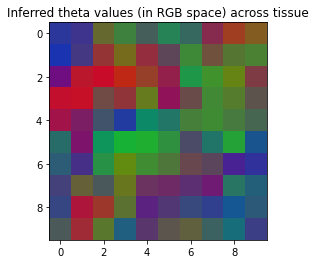

In [12]:
data._update_theta()
print(data.l)
plt.imshow(data.theta.reshape(side_length,side_length,3)[:,:,[1,2,0]])
plt.title("Inferred theta values (in RGB space) across tissue")
plt.show()

### vanilla LDA

first fit the model

In [13]:
%%time
data2 = LDAdataset(adata.X,adata.obsm["spatial"])
data2.vanillaGibbsSampling(150)

Iteration 149CPU times: user 31.6 s, sys: 1.47 s, total: 33 s
Wall time: 31.4 s


then inspect the results

5


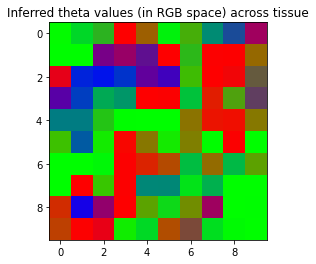

In [14]:
data2._update_theta()
print(data.l)
plt.imshow(data2.theta.reshape(side_length,side_length,3)[:,:,[0,1,2]])
plt.title("Inferred theta values (in RGB space) across tissue")
plt.show()

## Breast cancer dataset